## Classification results

In [49]:
import pandas as pd

results_df = pd.read_csv('data/res/all_subjects_classification_results.csv')

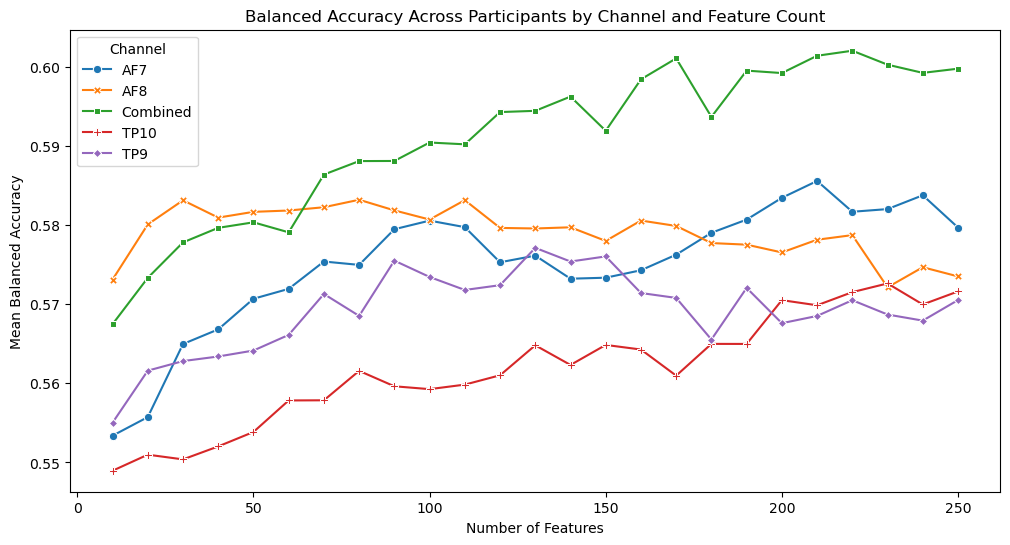

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean Balanced Accuracy
mean_bal_acc = results_df[(results_df['Metric'] == 'test_acc')
 #&(results_df['Subject'].isin([2]))
 #& (~results_df['Subject'].isin([2, 9, 5]))
].groupby(['Channel', 'Num_Features'])['Value'].mean().reset_index()
# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_bal_acc, x='Num_Features', y='Value', hue='Channel', style='Channel', markers=True, dashes=False)
plt.title('Balanced Accuracy Across Participants by Channel and Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('Mean Balanced Accuracy')
plt.legend(title='Channel')
plt.show()

In [60]:
import pandas as pd

# Assuming results_df is your DataFrame containing the results
# Filter the DataFrame for test accuracy and F1 score
filtered_df = results_df[(results_df['Metric'].isin(['test_acc', 'f1_score']))]

# Group by Metric and calculate standard deviation
sd_by_metric = filtered_df.groupby('Metric')['Value'].std()

# Display the standard deviation for each metric
print(sd_by_metric)


Metric
f1_score    0.078610
test_acc    0.048973
Name: Value, dtype: float64


In [59]:
import pandas as pd

# Assuming results_df is your DataFrame containing the results
# Filter the DataFrame for test accuracy and 10 features
filtered_df = results_df[(results_df['Metric'] == 'test_acc') & (results_df['Num_Features'] == 10)]

# Group by Channel and calculate mean accuracy
mean_accuracy_by_channel = filtered_df.groupby('Channel')['Value'].mean()

# Display the mean accuracy for each channel
print(mean_accuracy_by_channel)


Channel
AF7         0.553379
AF8         0.573103
Combined    0.567466
TP10        0.548955
TP9         0.555021
Name: Value, dtype: float64


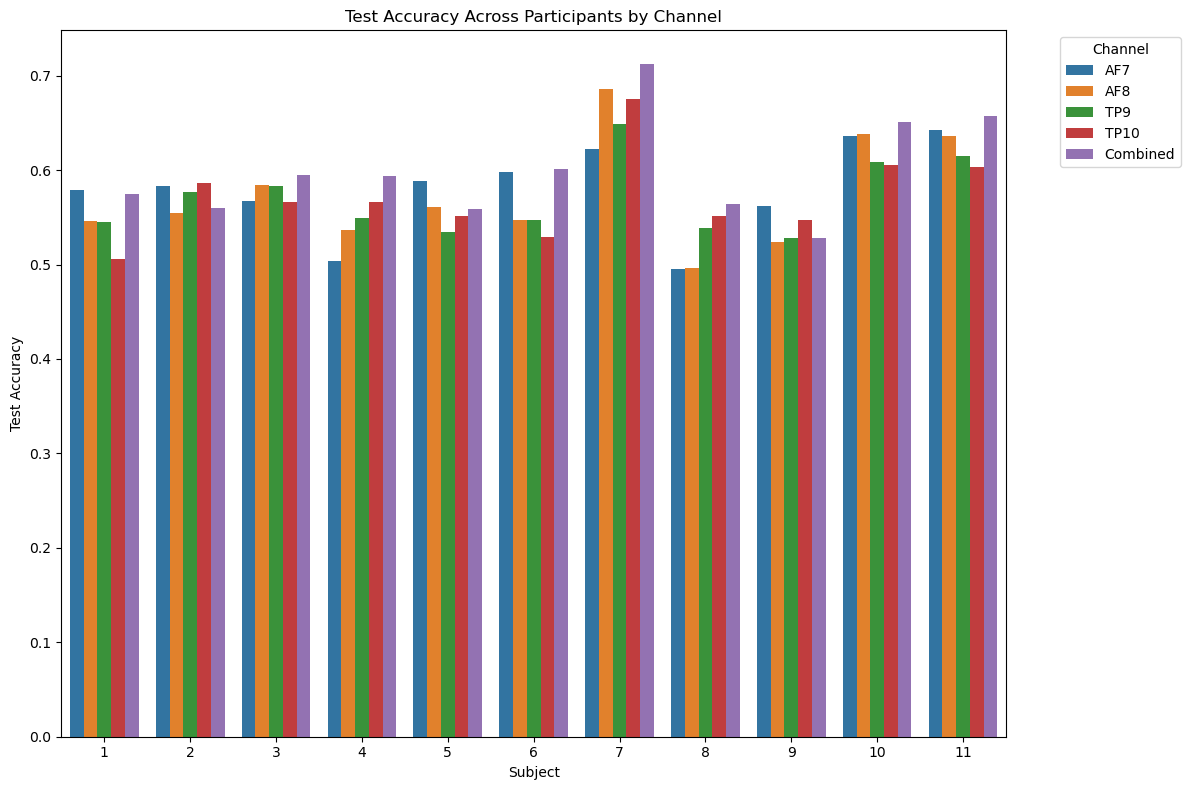

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = results_df[(results_df['Metric'] == 'test_acc') 
& (results_df['Num_Features'] == 200)
& (results_df['Channel'] == 'Combined')
]

# Set the figure size
plt.figure(figsize=(14, 8))

# Create the bar plot
sns.barplot(data=plot_data, x='Subject', y='Value', hue='Channel', errorbar=None)

# Adding plot title and labels
plt.title('Test Accuracy Across Participants by Channel')
plt.xlabel('Subject')
plt.ylabel('Test Accuracy')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


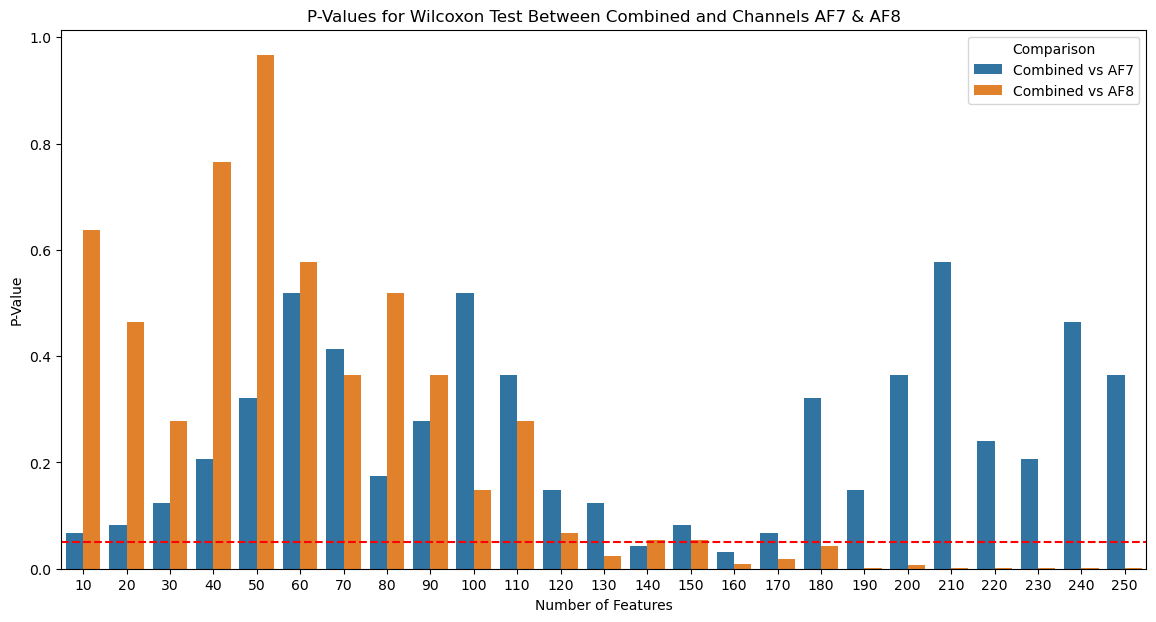

In [118]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame
# Filter data for 'test_acc' metric, required channels, and excluding specific subjects
channels = ['AF7', 'AF8', 'Combined']
filtered_data = results_df[(results_df['Metric'] == 'test_acc') & 
                           (results_df['Channel'].isin(channels))
                        #& (~results_df['Subject'].isin([ 5, 9]))
                            ]

# Prepare a dictionary to store results
wilcoxon_results = {'Num_Features': [], 'Comparison': [], 'Statistic': [], 'P-Value': []}

# Group by Num_Features to perform tests
grouped = filtered_data.groupby('Num_Features')

for name, group in grouped:
    combined_data = group[group['Channel'] == 'Combined']['Value']
    af7_data = group[group['Channel'] == 'AF7']['Value']
    af8_data = group[group['Channel'] == 'AF8']['Value']
    
    if len(combined_data) > 1 and len(af7_data) > 1:
        stat, p_value = wilcoxon(combined_data, af7_data, alternative='two-sided', zero_method='wilcox')
        wilcoxon_results['Num_Features'].append(name)
        wilcoxon_results['Comparison'].append('Combined vs AF7')
        wilcoxon_results['Statistic'].append(stat)
        wilcoxon_results['P-Value'].append(p_value)
        
    if len(combined_data) > 1 and len(af8_data) > 1:
        stat, p_value = wilcoxon(combined_data, af8_data, alternative='two-sided', zero_method='wilcox')
        wilcoxon_results['Num_Features'].append(name)
        wilcoxon_results['Comparison'].append('Combined vs AF8')
        wilcoxon_results['Statistic'].append(stat)
        wilcoxon_results['P-Value'].append(p_value)

# Convert results to DataFrame for easier reading and rename to avoid confusion
significance_df = pd.DataFrame(wilcoxon_results)

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(data=significance_df, x='Num_Features', y='P-Value', hue='Comparison')
plt.title('P-Values for Wilcoxon Test Between Combined and Channels AF7 & AF8')
plt.ylabel('P-Value')
plt.xlabel('Number of Features')
plt.axhline(0.05, color='red', linestyle='--')  # Significance threshold line
plt.legend(title='Comparison')
plt.show()

## Feature importance

In [45]:
import pandas as pd
mean_correlations = pd.read_csv('data/res/all_subjects_mean_correlations.csv')

In [46]:
mean_correlations.head()

,channel,band,feature_type,window_shift,subject_id,mean_correlation
0,AF7,alpha,approx_entropy,win-1,1,-0.006969
1,AF7,alpha,approx_entropy,win-2,1,0.003487
2,AF7,alpha,approx_entropy,win-3,1,0.009546
3,AF7,alpha,approx_entropy,win-4,1,0.001013
4,AF7,alpha,approx_entropy,win-5,1,0.008792


In [47]:
# Ensure the window_shift column is in integer form
mean_correlations['window_shift'] = mean_correlations['window_shift'].apply(lambda x: abs(int(x.replace('win', ''))))

# Make mean_correlation values absolute
mean_correlations['mean_correlation'] = mean_correlations['mean_correlation'].abs()

# Sort the data to ensure window shifts and feature types are in ascending order
mean_correlations.sort_values(by=['feature_type', 'window_shift'], inplace=True)

In [44]:
mean_correlations['window_shift'] = mean_correlations['window_shift'].apply(lambda x: abs(int(x.replace('win', ''))))
mean_correlations['mean_correlation'] = mean_correlations['mean_correlation'].abs()

# Aggregate mean correlations across all window shifts for each band and feature type
aggregated_correlations = mean_correlations.groupby(['band', 'feature_type']).mean_correlation.mean().reset_index()

# Sort the results to find the highest mean correlations
top_combinations = aggregated_correlations.sort_values(by='mean_correlation', ascending=False)

# Print the top combinations to see the most important ones
print(top_combinations.head(10))  # Adjust the number in head() to see more or fewer results

     band        feature_type  mean_correlation
11  delta              energy          0.102825
13  delta  standard_deviation          0.102566
14  delta     total_variation          0.102470
24  theta     total_variation          0.097473
23  theta  standard_deviation          0.096167
21  theta              energy          0.094734
4   alpha     total_variation          0.089877
1   alpha              energy          0.088869
3   alpha  standard_deviation          0.087955
10  delta      approx_entropy          0.048139


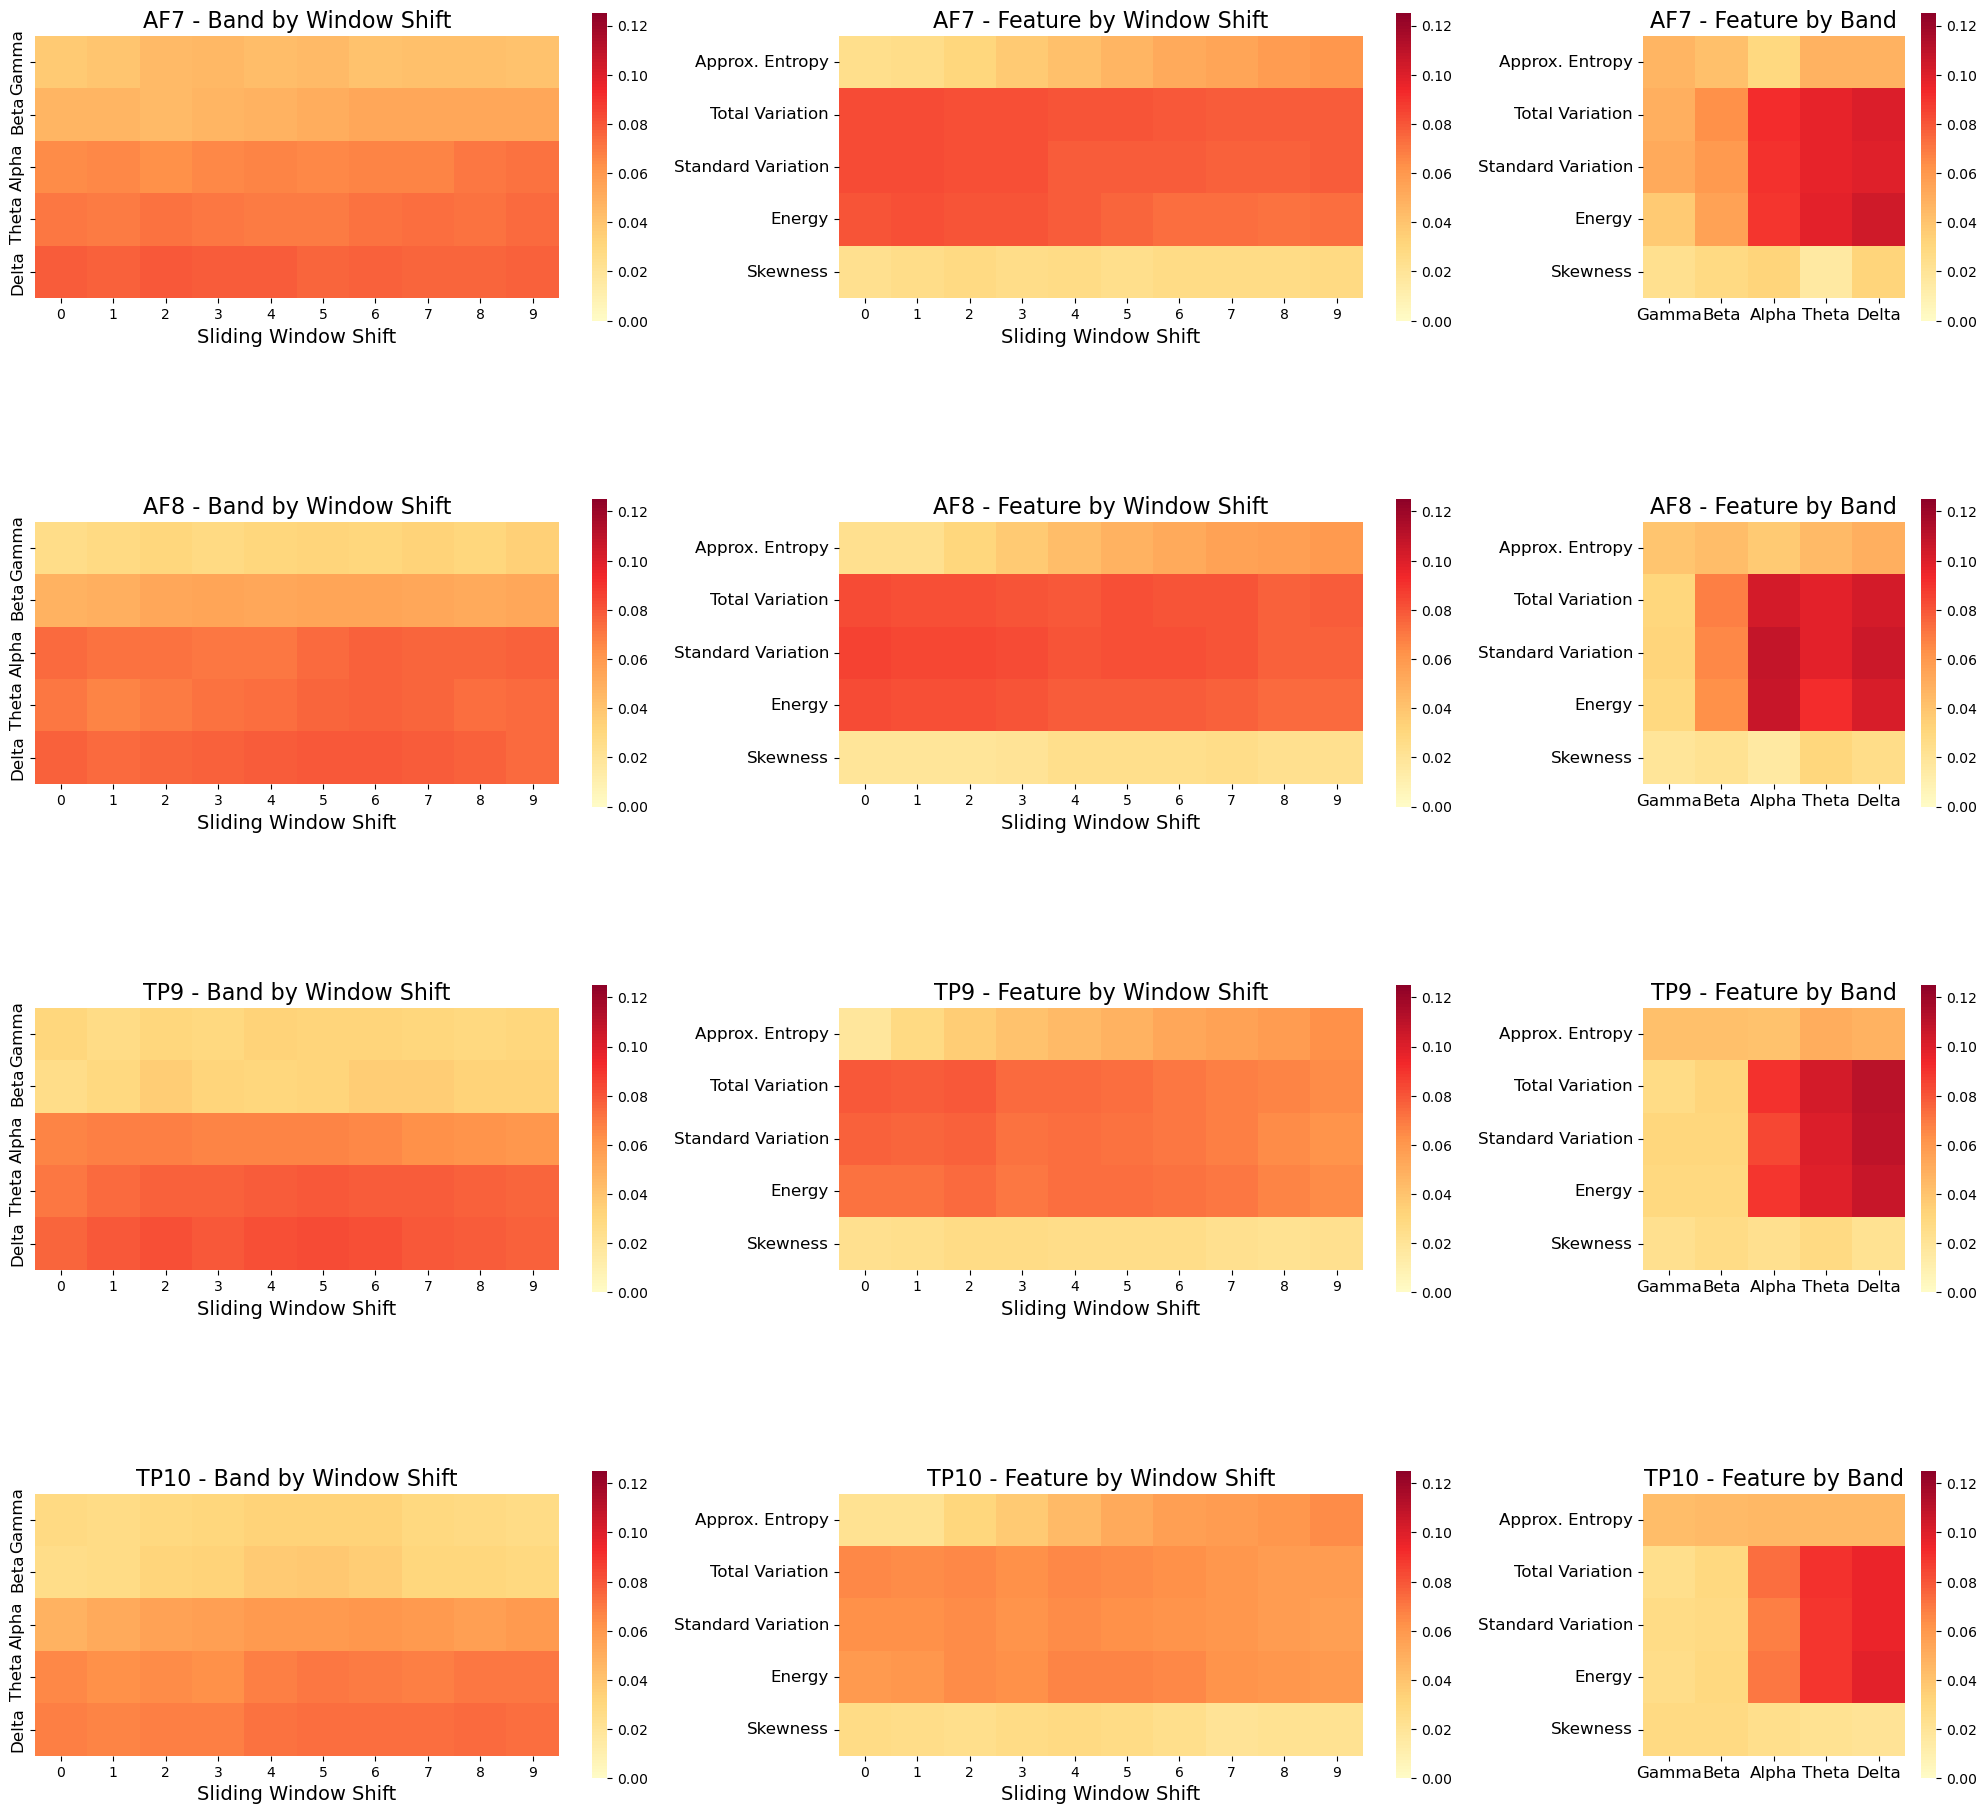

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the custom colormap
colors = ["#fffbc6", "#ffd67b", "#ff934a", "#f2272a", "#8e0128"]  # Light to dark
n_bins = 100  # Number of bins in the colormap
cmap_name = "custom_red"

# Create the colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Get unique channels
channels = ['AF7', 'AF8', 'TP9', 'TP10']

band_order = ['gamma', 'beta', 'alpha', 'theta', 'delta']
feature_type_order = ['approx_entropy', 'total_variation', 'standard_deviation', 'energy', 'skewness']

# Rename for display
band_labels = ['Gamma', 'Beta', 'Alpha', 'Theta', 'Delta']
feature_type_labels = ['Approx. Entropy', 'Total Variation', 'Standard Variation', 'Energy', 'Skewness']

# Set up the figure for the facet grid
fig, axs = plt.subplots(nrows=len(channels), ncols=3, figsize=(20, 5 * len(channels)), gridspec_kw={'width_ratios': [2, 2, 1]})

# Iterate over each channel
for i, channel in enumerate(channels):
    # Filter the DataFrame for the current channel
    channel_data = mean_correlations[mean_correlations['channel'] == channel]
    
    # Prepare data for heatmap (a)
    heatmap_a_data = channel_data.pivot_table(index='band', columns='window_shift', values='mean_correlation', aggfunc='mean')
    heatmap_a_data = heatmap_a_data.reindex(band_order)
    
    # Prepare data for heatmap (b)
    heatmap_b_data = channel_data.pivot_table(index='feature_type', columns='window_shift', values='mean_correlation', aggfunc='mean')
    heatmap_b_data = heatmap_b_data.reindex(feature_type_order)
    
    # Prepare data for heatmap (c)
    heatmap_c_data = channel_data.pivot_table(index='feature_type', columns='band', values='mean_correlation', aggfunc='mean')
    heatmap_c_data = heatmap_c_data.reindex(index=feature_type_order, columns=band_order)

    sns.heatmap(heatmap_a_data, ax=axs[i, 0], cmap=cm, annot=False, cbar=True, vmin=0, vmax=0.125, square=True, cbar_kws={"shrink": 0.6, "aspect": 20})
    axs[i, 0].set_title(f'{channel} - Band by Window Shift', fontsize=16)
    axs[i, 0].set_xlabel('Sliding Window Shift', fontsize=14)
    axs[i, 0].set_ylabel('', fontsize=14)
    axs[i, 0].set_yticklabels(band_labels, fontsize=12)
    
    sns.heatmap(heatmap_b_data, ax=axs[i, 1], cmap=cm, annot=False, cbar=True, vmin=0, vmax=0.125, square=True, cbar_kws={"shrink": 0.6, "aspect": 20})
    axs[i, 1].set_title(f'{channel} - Feature by Window Shift', fontsize=16)
    axs[i, 1].set_xlabel('Sliding Window Shift', fontsize=14)
    axs[i, 1].set_ylabel('', fontsize=14)
    axs[i, 1].set_yticklabels(feature_type_labels, fontsize=12)
    
    sns.heatmap(heatmap_c_data, ax=axs[i, 2], cmap=cm, annot=False, cbar=True, vmin=0, vmax=0.125, square=True, cbar_kws={"shrink": 0.6, "aspect": 20})
    axs[i, 2].set_title(f'{channel} - Feature by Band', fontsize=16)
    axs[i, 2].set_xlabel('', fontsize=14)
    axs[i, 2].set_ylabel('', fontsize=14)
    axs[i, 2].set_yticklabels(feature_type_labels, fontsize=12)
    axs[i, 2].set_xticklabels(band_labels, fontsize=12)

# Adjust layout
plt.tight_layout()
#plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust the spacing between subplots
plt.savefig('facet_grid_heatmaps.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()